## Notebook des Différents Tests de Modèles

In [1]:
import pandas as pd
import numpy as np

# lire mon jeu de données nettoyé et pret à utiliser pour entrainer et tester les modèles
seattle_df = pd.read_csv("combined15_16.csv")

# combien de lignes et combien de colonnes?
print("Il y a:", seattle_df.shape[0], "lignes et", seattle_df.shape[1], "colonnes dans le dataframe.")

Il y a: 3164 lignes et 27 colonnes dans le dataframe.


In [2]:
# fonction pour obtenir informations sur les valeurs manquantes
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def vals_manquantes(data):
    # nombre de valeurs manquantes pour chaque colonne 
    missing_data = data.isnull().sum()
    # pourcentage de valeurs manquantes dans le dataframe 
    null_counts_pct = missing_data / data.shape[0] * 100
    # plus facile a visualiser ensemble (le nombre et le pourcentage):
    nulls_df = pd.DataFrame({'null_counts': missing_data, 'null_pct': null_counts_pct})
    # ranger par pourcentages
    nulls_df = nulls_df.sort_values(by = "null_pct")
    return nulls_df

In [3]:
# valeurs manquantes pour le jeu de données 
vals_manquantes(seattle_df)

,null_counts,null_pct
Unnamed: 0,0,0.000000
GHGEmissionsIntensity_kgCO2e_ft2,0,0.000000
GHGEmissions_MetricTonsCO2e,0,0.000000
LargestPropertyUseT_Other,0,0.000000
LargestPropertyUseT_Non_Refrig_Warehouse,0,0.000000
LargestPropertyUseT_Office,0,0.000000
LargestPropertyUseType,0,0.000000
SteamUse(kBtu)_Maj,0,0.000000
NaturalGas(kBtu)_Maj,0,0.000000
ElectricitykBtu_Maj,0,0.000000


In [12]:
# fonction pour plot les residuals 
from yellowbrick.regressor import ResidualsPlot

def plot_resid(model, hist, qqplot, X_train_energ, y_train_energ, X_test_energ, y_test_energ):
    
    # définir taille du graphique
    fig, axes = plt.subplots(figsize = [12, 8])
    
    visualizer = ResidualsPlot(model,hist = hist,qqplot = qqplot,train_color = 'y',test_color = 'b')
    visualizer.fit(X_train_energ, y_train_energ) 
    # Evaluer le modèle sur les données test
    visualizer.score(X_test_energ, y_test_energ)  
    visualizer.show()                 

In [13]:
# fonction pour automatiquement remplir le dataframe qui va être utilisé pour comparer les modèles entre eux

from sklearn import metrics, datasets, neighbors
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import sys
import warnings
import itertools
    
def compare_models_df(df, model, y_test, y_pred, elapsed, executionTimeMin):
    
    # calculer r^2
    df.loc[model, "R-squared"] = round(metrics.r2_score(y_test, y_pred), 3)
    
    # calculer MAe
    df.loc[model, "MAE (version log)"] = round(metrics.mean_absolute_error(y_test, y_pred), 3)
    
    y_test_exp = np.exp(y_test) 
    y_pred_exp = np.exp(y_pred)
    
    # calculer la RMSLE dans l'ordre de grandeur de départ
    df.loc[model, 
           "RMSLE (Root Mean Squared Log Error)"] = round(np.sqrt(metrics.mean_squared_log_error(y_test_exp, 
                                                                          y_pred_exp)), 3)
    # temps d'execution en secondes
    df.loc[model, "Execution time in seconds"] = str(round(elapsed, 6))

    # print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y_test1, y_pred_energsite))))

    return df


## Première Variable Dépendente : Site Energy Use

In [14]:
# créer un dataframe pour la comparaison des modèles
energsit_results = pd.DataFrame(index = ["Dummy Regressor (strategy = 'mean')", 
                                         "Linear Regression",
                                         "Linear Regression, after outlier removal",
                                         "Random Forest",
                                         "Random Forest (Feature Selection)",
                                         "Random Forest Best Model from Grid Search",
                                         "Random Forest with EnergyStar",
                                         "Random Forest (Feature Selection) with EnergyStar",
                                         "Random Forest Best Model from Grid Search with EnergyStar",
                                         "XGBoost",
                                         "XGBoost with EnergyStar",
                                         "XGBoost Best Model from Grid Search with EnergyStar"],
                                columns = ["R-squared", 
                                           "MAE (version log)",  
                                           "RMSLE (Root Mean Squared Log Error)",
                                           "Execution time in seconds"])

In [15]:
from numpy import asarray
from sklearn.preprocessing import StandardScaler
# colonnes de prédiction
cols_site = ['ENERGYSTARScore', 
             'Age', 'NumberofFloors', 'NumberofBuildings',
             'PropertyGFATotal', 'Building_GFA_percentage', 'Parking_GFA_percentage',
             'ElectricitykBtu_Maj', 'NaturalGas(kBtu)_Maj', 'SteamUse(kBtu)_Maj', 
             'LargestPropertyUseT_Office',
             'LargestPropertyUseT_Non_Refrig_Warehouse', 'LargestPropertyUseT_Other']

# centrage et réduction des variables de prédiction pour le dataframe original
scaler = StandardScaler()
scaled_energsite = scaler.fit_transform(seattle_df[cols_site].copy())

scaled_energsite = pd.DataFrame(scaled_energsite)

# renommer les colonnes correctement 
scaled_energsite.columns = cols_site


In [16]:
# les données sont séparées en train/test 

from sklearn.model_selection import train_test_split

# les données de prédiction
X_energsite1 = scaled_energsite.copy()

# la variable dépendente pour cette première partie est la version log de Site Energy Use
y_energsite1 = seattle_df['Log_SiteEnergyUse'].copy()

# on veut d'abord tester les modèles sans la variable EnergyStarScore
X_energsite2 = pd.DataFrame(X_energsite1).drop('ENERGYSTARScore', axis=1).copy()

X_train_energ, X_test_energ, y_train_energ, y_test_energ = train_test_split(X_energsite2, 
                                                                            y_energsite1, 
                                                                            test_size= 0.2, random_state = 0)

In [17]:
# on va créer un version test/ train avec le EnergyStar Score 

build = pd.concat([X_energsite1.copy(), y_energsite1.copy()], axis =1)

# on supprime toutes les individus dont le EnergyStar Score est manquant. Aucune autre colonne à des valeurs 
# manquantes, on utilise donc dropna() directement
build = build.dropna()

X_energsite_star = build.drop(['Log_SiteEnergyUse'], axis=1).copy()
y_energsite_star = build['Log_SiteEnergyUse']

# les données sont séparées en train/test 
X_train_star, X_test_star, y_train_star, y_test_star = train_test_split(X_energsite_star, 
                                                                        y_energsite_star,
                                                                        test_size= 0.2, random_state = 0)

In [ ]:
# verification des valeurs manquantes pour version avec EnergyStar
vals_manquantes(build)

## Dummy Regressor : Site Energy Use

In [18]:
from sklearn.dummy import DummyRegressor 
import timeit
# compter le temps d'execution de dummy regressor 
start_time = timeit.default_timer()

dummy_mean = DummyRegressor(strategy = 'mean')
dummy_mean.fit(X_train_energ, y_train_energ)
y_pred_energsite = dummy_mean.predict(X_test_energ)

# résultats du temps d'execution
elapsed = timeit.default_timer() - start_time
executionTimeMin = elapsed / 60

# ajouter les informations du modèle dummy au dataframe du comparaison : energsit_results
energsit_results = compare_models_df(energsit_results.copy(), "Dummy Regressor (strategy = 'mean')", 
                                     y_test_energ.copy(), y_pred_energsite, 
                                     elapsed, executionTimeMin)
energsit_results

,R-squared,MAE (version log),RMSLE (Root Mean Squared Log Error),Execution time in seconds
Dummy Regressor (strategy = 'mean'),-0.0,1.083,1.371,0.000576
Linear Regression,NaN,NaN,NaN,NaN
"Linear Regression, after outlier removal",NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN
Random Forest (Feature Selection),NaN,NaN,NaN,NaN
Random Forest Best Model from Grid Search,NaN,NaN,NaN,NaN
Random Forest with EnergyStar,NaN,NaN,NaN,NaN
Random Forest (Feature Selection) with EnergyStar,NaN,NaN,NaN,NaN
Random Forest Best Model from Grid Search with EnergyStar,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN


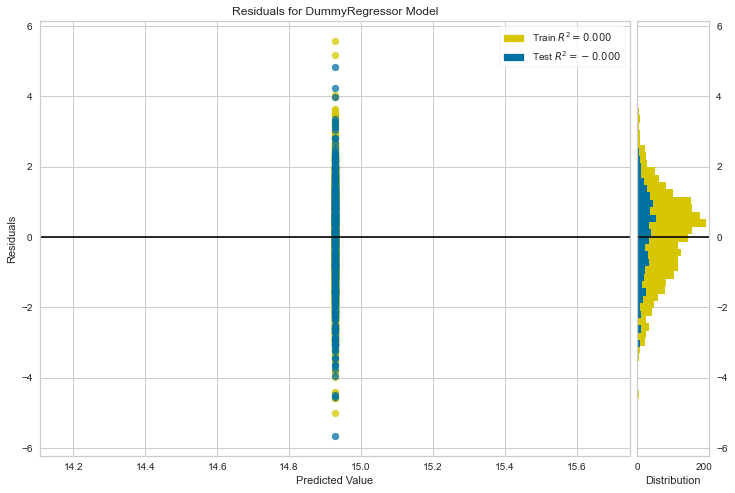

In [19]:
plot_resid(dummy_mean, True, False, X_train_energ, y_train_energ, X_test_energ, y_test_energ)
 

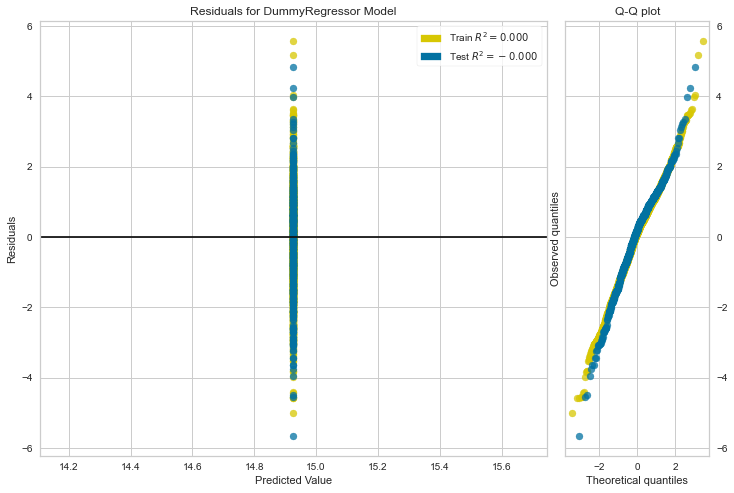

In [20]:
plot_resid(dummy_mean, False, True, X_train_energ, y_train_energ, X_test_energ, y_test_energ)
 

## Linear Regression : Site Energy Use

In [21]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn import metrics, datasets, neighbors
import timeit

# compter le temps d'execution de linear regression 
start_time = timeit.default_timer()

lr = LinearRegression()
model = lr.fit(X_train_energ, y_train_energ)
y_pred_energsite2 = lr.predict(X_test_energ)

# évaluer temps 
elapsed = timeit.default_timer() - start_time
executionTimeMin = elapsed / 60

# ajouter les informations du modèle linéaire au dataframe du comparaison : energsit_results
energsit_results = compare_models_df(energsit_results.copy(), "Linear Regression", 
                                     y_test_energ.copy(), y_pred_energsite2, 
                                     elapsed, executionTimeMin)
energsit_results

,R-squared,MAE (version log),RMSLE (Root Mean Squared Log Error),Execution time in seconds
Dummy Regressor (strategy = 'mean'),-0.0,1.083,1.371,0.000576
Linear Regression,-0.878,0.859,1.879,0.006766
"Linear Regression, after outlier removal",NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN
Random Forest (Feature Selection),NaN,NaN,NaN,NaN
Random Forest Best Model from Grid Search,NaN,NaN,NaN,NaN
Random Forest with EnergyStar,NaN,NaN,NaN,NaN
Random Forest (Feature Selection) with EnergyStar,NaN,NaN,NaN,NaN
Random Forest Best Model from Grid Search with EnergyStar,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN


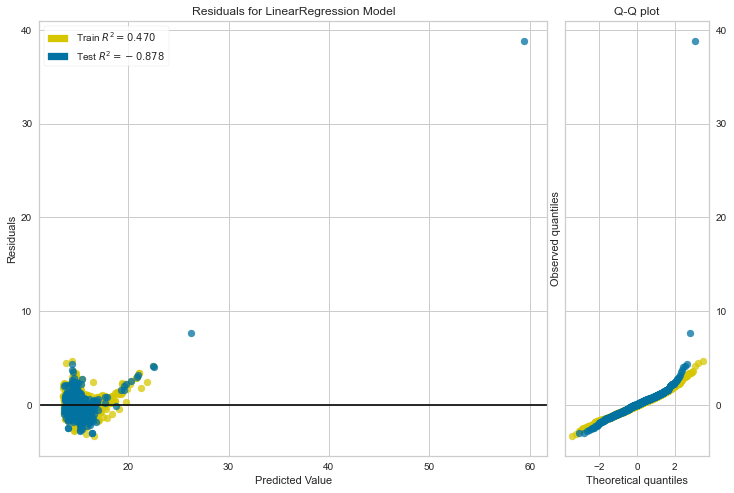

In [22]:
plot_resid(lr, False, True, X_train_energ, y_train_energ, X_test_energ, y_test_energ)


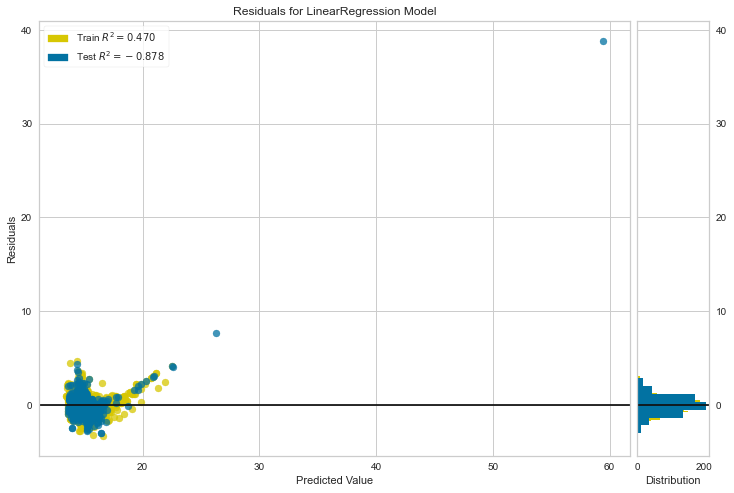

In [23]:
plot_resid(lr, True, False, X_train_energ, y_train_energ, X_test_energ, y_test_energ)


In [24]:
# on va refaire la même chose que pour la cellule au-dessus, mais en supprimant les 2 outliers 
# des résultats de regression linéaire
list_num = [285, 342]

seattle_less = seattle_df.copy()
for num in list_num:
    indexNames = seattle_less[seattle_less['Unnamed: 0'] == num].index
    seattle_less.drop(indexNames, inplace =True)

# centrage et réduction pour le dataframe sans les outliers
scaled_energsite_less = scaler.fit_transform(seattle_less[cols_site].copy())
scaled_energsite_less = pd.DataFrame(scaled_energsite_less)

# renommer les colonnes correctement 
scaled_energsite_less.columns = cols_site

# les données sont séparées en train/test 
X_energsite_prev = scaled_energsite_less.copy()
y_energsite_prev = seattle_less['Log_SiteEnergyUse'].copy()
# pour l'instant on ne veut toujours pas utiliser EnergyStar Score
X_energsite = pd.DataFrame(X_energsite_prev).drop('ENERGYSTARScore', axis=1).copy()

# séparer le dataframe en train / test
X_train_energ_lin, X_test_energ_lin, y_train_energ_lin, y_test_energ_lin = train_test_split(X_energsite, 
                                                                            y_energsite_prev, 
                                                                            test_size= 0.2, random_state = 0)

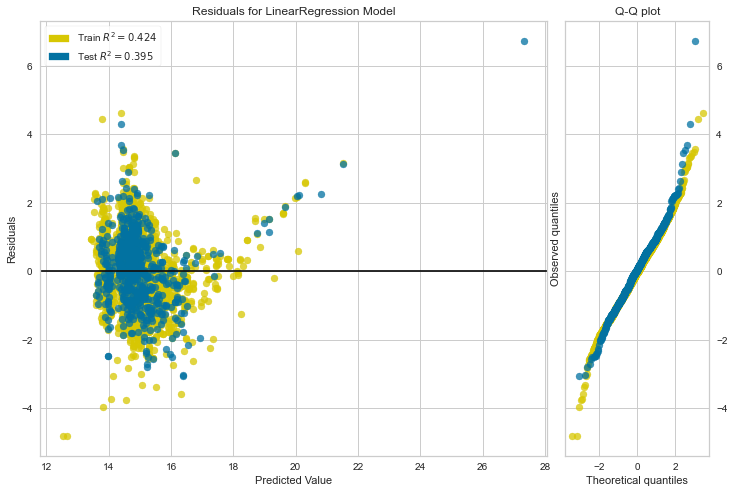

,R-squared,MAE (version log),RMSLE (Root Mean Squared Log Error),Execution time in seconds
Dummy Regressor (strategy = 'mean'),-0.0,1.083,1.371,0.000576
Linear Regression,-0.878,0.859,1.879,0.006766
"Linear Regression, after outlier removal",0.391,0.816,1.029,0.005392
Random Forest,NaN,NaN,NaN,NaN
Random Forest (Feature Selection),NaN,NaN,NaN,NaN
Random Forest Best Model from Grid Search,NaN,NaN,NaN,NaN
Random Forest with EnergyStar,NaN,NaN,NaN,NaN
Random Forest (Feature Selection) with EnergyStar,NaN,NaN,NaN,NaN
Random Forest Best Model from Grid Search with EnergyStar,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN


In [25]:
# linear regression sans les deux outliers 
start_time = timeit.default_timer()

lr2 = LinearRegression()
model = lr2.fit(X_train_energ_lin, y_train_energ_lin)
y_pred_energsite2 = lr2.predict(X_test_energ_lin)

# évaluer temps 
elapsed = timeit.default_timer() - start_time
executionTimeMin = elapsed / 60

plot_resid(lr2, False, True, X_train_energ, y_train_energ, X_test_energ, y_test_energ)

# ajouter les informations du deuxième modèle linéaire au dataframe du comparaison : energsit_results
energsit_results = compare_models_df(energsit_results.copy(), "Linear Regression, after outlier removal", 
                                     y_test_energ_lin, y_pred_energsite2, elapsed, executionTimeMin)
energsit_results

In [ ]:
from statsmodels.formula.api import ols

X_for_ols = sm.add_constant(X_train_energ)
est = sm.OLS(y_train_energ, X_for_ols)
est2 = est.fit()

print(est2.summary())

In [ ]:
cols_site = ['Age',
             'NumberofBuildings', 'NumberofFloors', 
             'PropertyGFATotal', 'Building_GFA_percentage', 'Parking_GFA_percentage',
             'ElectricitykBtu_Maj', 'NaturalGas(kBtu)_Maj', 'SteamUse(kBtu)_Maj', 
             'LargestPropertyUseT_Office',
             'LargestPropertyUseT_Non_Refrig_Warehouse', 'LargestPropertyUseT_Other']

cols_site2 = ['Age', 'NumberofBuildings',  'NumberofFloors', 
                  'PropertyGFATotal', 'Building_GFA_percentage', 'Parking_GFA_percentage',
                  'ElectricitykBtu_Maj', 'SteamUse(kBtu)_Maj',
                  'LargestPropertyUseT_Office',
                  'LargestPropertyUseT_Non_Refrig_Warehouse', 'LargestPropertyUseT_Other']
X_for_ols2 = sm.add_constant(X_train_energ[cols_site2])
est = sm.OLS(y_train_energ, X_for_ols2)
est2 = est.fit()

print(est2.summary())


In [ ]:
cols_site2 = ['Age',  'NumberofBuildings',
                  'PropertyGFATotal', 'Building_GFA_percentage', 'Parking_GFA_percentage',
                  'ElectricitykBtu_Maj', 'SteamUse(kBtu)_Maj',
                  'LargestPropertyUseT_Office',
                  'LargestPropertyUseT_Non_Refrig_Warehouse', 'LargestPropertyUseT_Other']

X_for_ols2 = sm.add_constant(X_train_energ[cols_site2])
est = sm.OLS(y_train_energ, X_for_ols2)
est2 = est.fit()

print(est2.summary())


## Random Forest: Site Energy Use

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score

# compter le temps d'execution 
start_time = timeit.default_timer()

rfc = RandomForestRegressor(n_estimators = 500)
model = rfc.fit(X_train_energ, y_train_energ)
print(X_train_energ.shape)

y_pred_energsite3 = rfc.predict(X_test_energ)

elapsed = timeit.default_timer() - start_time
executionTimeMin = elapsed / 60

# ajouter les informations du modèle random forest au dataframe du comparaison : energsit_results
energsit_results = compare_models_df(energsit_results.copy(), "Random Forest",
                                     y_test_energ.copy(), y_pred_energsite3, 
                                     elapsed, executionTimeMin)


from sklearn.feature_selection import SelectFromModel
start_time = timeit.default_timer()

# on va utiliser la fonction  SelectFromModel  qui utilise la propriété du modèle qu'on vient de créer  
# model.feature_importances_ qui permet d'évaluer l'importance relative des features fournies à la base 
# (sur une échelle de 0 à 1). 
select = SelectFromModel(rfc, prefit=True, threshold = 0.003)
X_train2 = select.transform(X_train_energ)
# print les variables utilisées (True) et les variables non selectionnées (False)
print(select.get_support())
print(X_train2.shape)

rfc2 = RandomForestRegressor(n_estimators= 500)
rfc2 = rfc2.fit(X_train2, y_train_energ)
X_test2 = select.transform(X_test_energ)
y_pred_energsite4 = rfc2.predict(X_test2)

elapsed = timeit.default_timer() - start_time
executionTimeMin = elapsed / 60

# ajouter les informations du modèle au dataframe du comparaison : energsit_results
energsit_results = compare_models_df(energsit_results.copy(), "Random Forest (Feature Selection)",
                                     y_test_energ.copy(), y_pred_energsite4, 
                                     elapsed, executionTimeMin)
energsit_results

(2531, 12)
[ True  True  True  True  True  True  True  True False  True  True  True]
(2531, 11)


,R-squared,MAE (version log),RMSLE (Root Mean Squared Log Error),Execution time in seconds
Dummy Regressor (strategy = 'mean'),-0.0,1.083,1.371,0.000576
Linear Regression,-0.878,0.859,1.879,0.006766
"Linear Regression, after outlier removal",0.391,0.816,1.029,0.005392
Random Forest,0.808,0.376,0.601,3.354045
Random Forest (Feature Selection),0.81,0.375,0.598,3.324464
Random Forest Best Model from Grid Search,NaN,NaN,NaN,NaN
Random Forest with EnergyStar,NaN,NaN,NaN,NaN
Random Forest (Feature Selection) with EnergyStar,NaN,NaN,NaN,NaN
Random Forest Best Model from Grid Search with EnergyStar,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN


In [ ]:
plot_resid(rfc, False, True, X_train_energ, y_train_energ, X_test_energ, y_test_energ)

In [ ]:
plot_resid(rfc2, False, True, X_train2, y_train_energ, X_test2, y_test_energ)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Créer le parameter grid pour random forest
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [5, 6, 8, 10, 20, 30, 35],
    'max_features': [5, 7, 8, 10, 11, 12],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 3, 4, 5, 6],
    'n_estimators': [150, 300, 500, 600, 700, 800, 900, 1000]
}

rf = RandomForestRegressor()
RFgs = grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                                  cv = 5, n_jobs = -1, verbose = 4, scoring = "neg_root_mean_squared_error")
RFgs.fit(X_train_energ, y_train_energ)

print(RFgs.best_score_)
# Print les parameters du meilleur modèle
print(RFgs.best_params_)
# Print le test score du meilleur modèle
clfRFR = RFgs.best_estimator_
print('Test accuracy: %.3f' % clfRFR.score(X_test_energ, y_test_energ))


In [27]:
# créer un modèle random forest avec les paramètres du meilleur modèle trouvé par Grid Search
start_time = timeit.default_timer()

rfc = RandomForestRegressor(bootstrap = False, max_depth = 30, max_features = 7, min_samples_leaf = 1,
                            min_samples_split = 2, n_estimators = 600)
bestRFR = rfc.fit(X_train_energ, y_train_energ)
y_pred_energsite_rfgb = bestRFR.predict(X_test_energ)

elapsed = timeit.default_timer() - start_time
executionTimeMin = elapsed / 60

# ajouter les informations du modèle au dataframe du comparaison : energsit_results
energsit_results = compare_models_df(energsit_results.copy(), "Random Forest Best Model from Grid Search",
                                     y_test_energ.copy(), y_pred_energsite_rfgb, 
                                     elapsed, executionTimeMin)

energsit_results

,R-squared,MAE (version log),RMSLE (Root Mean Squared Log Error),Execution time in seconds
Dummy Regressor (strategy = 'mean'),-0.0,1.083,1.371,0.000576
Linear Regression,-0.878,0.859,1.879,0.006766
"Linear Regression, after outlier removal",0.391,0.816,1.029,0.005392
Random Forest,0.808,0.376,0.601,3.354045
Random Forest (Feature Selection),0.81,0.375,0.598,3.324464
Random Forest Best Model from Grid Search,0.82,0.294,0.582,3.676381
Random Forest with EnergyStar,NaN,NaN,NaN,NaN
Random Forest (Feature Selection) with EnergyStar,NaN,NaN,NaN,NaN
Random Forest Best Model from Grid Search with EnergyStar,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN


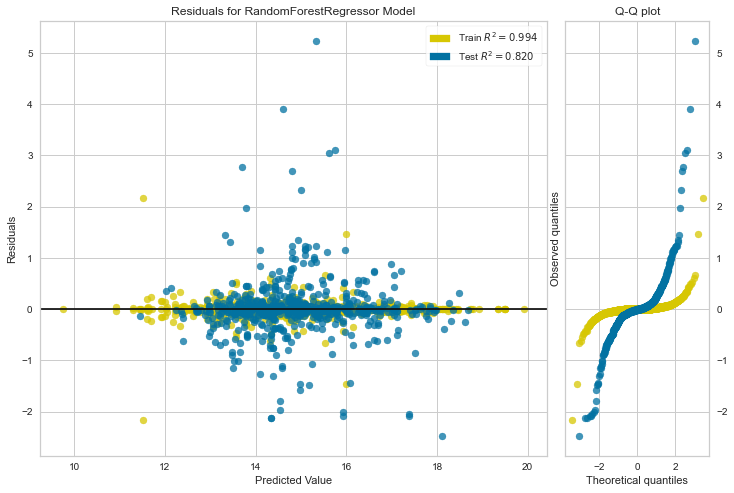

In [28]:
plot_resid(rfc, False, True, X_train_energ, y_train_energ, X_test_energ, y_test_energ)


## Random Forest avec EnergyStar: Site Energy Use

In [29]:
# compter le temps d'execution de random forest avec energystar
start_time = timeit.default_timer()

rfc = RandomForestRegressor(n_estimators = 500)

model = rfc.fit(X_train_star, y_train_star)
print(X_train_star.shape)
y_pred_energsite_star = rfc.predict(X_test_star)

elapsed = timeit.default_timer() - start_time
executionTimeMin = elapsed / 60

# ajouter les informations du modèle au dataframe du comparaison : energsit_results
energsit_results = compare_models_df(energsit_results.copy(), "Random Forest with EnergyStar",
                                     y_test_star, y_pred_energsite_star, 
                                     elapsed, executionTimeMin)


from sklearn.feature_selection import SelectFromModel
start_time = timeit.default_timer()

# selection de features
select = SelectFromModel(rfc, prefit=True, threshold=0.003)
X_train2 = select.transform(X_train_star)
print(select.get_support())
print(X_train2.shape)

# modèle random forest avec energystarscore
rfc2 = RandomForestRegressor(n_estimators= 500)
rfc2 = rfc2.fit(X_train2, y_train_star)
X_test2 = select.transform(X_test_star)

y_pred_energsite_star = rfc2.predict(X_test2)

# temps d'execution
elapsed = timeit.default_timer() - start_time
executionTimeMin = elapsed / 60

# ajouter les informations du modèle au dataframe du comparaison : energsit_results
energsit_results = compare_models_df(energsit_results.copy(), 
                                     "Random Forest (Feature Selection) with EnergyStar",
                                     y_test_star, y_pred_energsite_star, 
                                     elapsed, executionTimeMin)

(1683, 13)
[ True  True  True False  True  True  True  True  True False  True  True
  True]
(1683, 11)


In [ ]:
plot_resid(rfc, False, True, X_train_star, y_train_star, X_test_star, y_test_star)


In [ ]:
plot_resid(rfc2, True, False, X_train2, y_train_star, X_test2, y_test_star)


In [ ]:
# paramètres à tester avec le grid search
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [5, 8, 10, 15, 20, 25, 30],
    'max_features': [5, 7, 8, 10, 11, 12, 13],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 3, 4, 5, 6],
    'n_estimators': [150, 300, 400, 500, 600, 700]
}


rf = RandomForestRegressor()
# grid search 
RFgs = grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                                  cv = 5, n_jobs = -1, verbose = 4, scoring = "neg_root_mean_squared_error")

RFgs.fit(X_train_star, y_train_star)

# training score du meilleur modèle
print(RFgs.best_score_)
# paramètres du meilleur modèle
print(RFgs.best_params_)
# test score du meilleur modèle
clfRFR = RFgs.best_estimator_
print('Test accuracy: %.3f' % clfRFR.score(X_test_star, y_test_star))

Le modèle ci-dessous, 'Random Forest Best Model from Grid Search with EnergyStar', est le meilleur modèle de prédiction pour la target "Site Energy Use"

In [30]:
# Ce modèle est le meilleur modèle de prédiction pour la target "Site Energy Use"

start_time = timeit.default_timer()

rfc_star = RandomForestRegressor(bootstrap = False, max_depth = 25, max_features = 7, min_samples_leaf = 1,
                            min_samples_split = 2, n_estimators = 400)

bestRFR_star = rfc_star.fit(X_train_star, y_train_star)

y_pred_energsite_rfgb = bestRFR_star.predict(X_test_star)

elapsed = timeit.default_timer() - start_time
executionTimeMin = elapsed / 60

energsit_results = compare_models_df(energsit_results.copy(), 
                                     "Random Forest Best Model from Grid Search with EnergyStar",
                                     y_test_star, y_pred_energsite_rfgb, 
                                     elapsed, executionTimeMin)
                              
energsit_results

,R-squared,MAE (version log),RMSLE (Root Mean Squared Log Error),Execution time in seconds
Dummy Regressor (strategy = 'mean'),-0.0,1.083,1.371,0.000576
Linear Regression,-0.878,0.859,1.879,0.006766
"Linear Regression, after outlier removal",0.391,0.816,1.029,0.005392
Random Forest,0.808,0.376,0.601,3.354045
Random Forest (Feature Selection),0.81,0.375,0.598,3.324464
Random Forest Best Model from Grid Search,0.82,0.294,0.582,3.676381
Random Forest with EnergyStar,0.878,0.279,0.441,2.730984
Random Forest (Feature Selection) with EnergyStar,0.877,0.281,0.443,2.750639
Random Forest Best Model from Grid Search with EnergyStar,0.905,0.219,0.389,1.885672
XGBoost,NaN,NaN,NaN,NaN


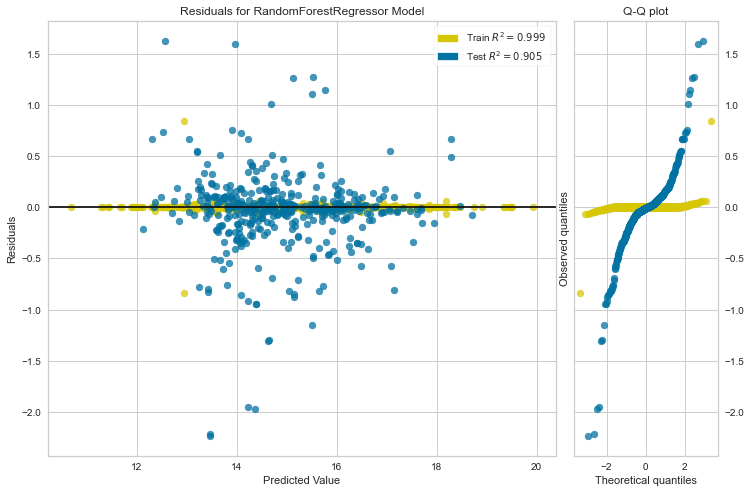

In [31]:
plot_resid(rfc_star, False, True, X_train_star, y_train_star, X_test_star, y_test_star)

## XG Boost: Site Energy Use

In [32]:
import xgboost as xgb

start_time = timeit.default_timer()

regressor = xgb.XGBRegressor(
    n_estimators= 1000,
    reg_lambda = 1,
    alpha = 0, 
    gamma = 0,
    max_depth = 6
)

regressor.fit(X_train_energ, y_train_energ)

y_pred_energsite5 = regressor.predict(X_test_energ)

elapsed = timeit.default_timer() - start_time
executionTimeMin = elapsed / 60

energsit_results = compare_models_df(energsit_results.copy(), 
                                     "XGBoost",
                                     y_test_energ, y_pred_energsite5, 
                                     elapsed, executionTimeMin)

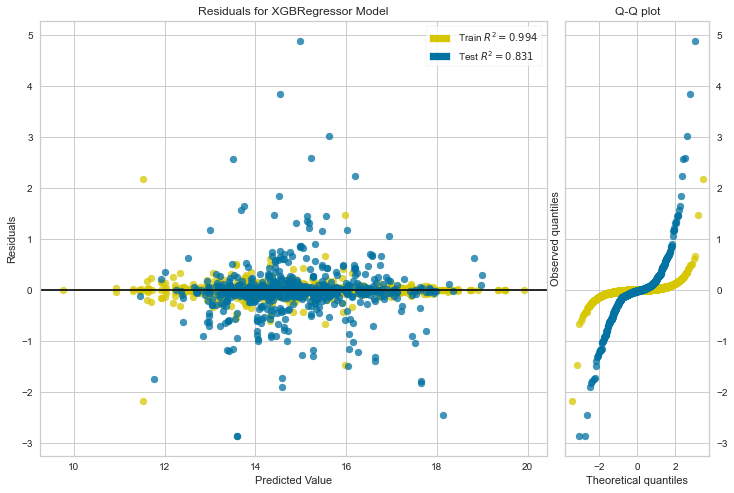

In [33]:
plot_resid(regressor, False, True, X_train_energ, y_train_energ, X_test_energ, y_test_energ)


In [ ]:
plot_resid(regressor, True , False, X_train_energ, y_train_energ, X_test_energ, y_test_energ)


## XGBoost avec EnergyStar : Site Energy Use 

In [34]:
start_time = timeit.default_timer()

regressor = xgb.XGBRegressor(
    n_estimators= 1000,
    reg_lambda=1,
    gamma=0,
    max_depth = 6,
)

regressor.fit(X_train_star, y_train_star)

y_pred_xgstar = regressor.predict(X_test_star)

elapsed = timeit.default_timer() - start_time
executionTimeMin = elapsed / 60

energsit_results = compare_models_df(energsit_results.copy(), 
                                     "XGBoost with EnergyStar",
                                     y_test_star, y_pred_xgstar, 
                                     elapsed, executionTimeMin)

In [ ]:
xgb_model =  xgb.XGBRegressor()

parameters = {'gamma': [0, 1],
              'reg_lambda': [1, 2, 3],
              'learning_rate': [0.03, 0.05, 0.07, 0.1, 0.15, 0.2], #so called `eta` value
              'max_depth': [4, 5, 6, 8, 9],
              'min_child_weight': [0.1, 0.2, 0.5, 1, 2],
              'subsample': [0.7, 0.8, 0.9, 0.95],
              'n_estimators': [400, 600, 800, 1000], #number of trees, change it to 1000 for better results
             }

XGBgs = GridSearchCV(xgb_model, parameters, n_jobs= -1, 
                     cv = 5, 
                     verbose = 4, refit=True, scoring = "neg_root_mean_squared_error")

XGBgs.fit(X_train_star, y_train_star)

# training score du meilleur modèle
print(XGBgs.best_score_)
# paramètres du meilleur modèle
print(XGBgs.best_params_)
# test score du meilleur modèle
clfXGB = XGBgs.best_estimator_
print('Test accuracy: %.3f' % clfXGB.score(X_test_star, y_test_star))

In [35]:
start_time = timeit.default_timer()

# modèle avec les paramètres déterminés grâce au grid search
regressor = xgb.XGBRegressor(
    n_estimators = 1000,
    reg_lambda = 1,
    gamma = 0,
    max_depth = 7,
    learning_rate = 0.05,
    min_child_weight = 2, 
    subsample = 0.8)

clfXGB = regressor.fit(X_train_star, y_train_star)

y_pred_energsite_xggs = clfXGB.predict(X_test_star)

elapsed = timeit.default_timer() - start_time
executionTimeMin = elapsed / 60


energsit_results = compare_models_df(energsit_results.copy(), 
                                     "XGBoost Best Model from Grid Search with EnergyStar",
                                     y_test_star, y_pred_energsite_xggs,
                                     elapsed, executionTimeMin)
energsit_results


,R-squared,MAE (version log),RMSLE (Root Mean Squared Log Error),Execution time in seconds
Dummy Regressor (strategy = 'mean'),-0.0,1.083,1.371,0.000576
Linear Regression,-0.878,0.859,1.879,0.006766
"Linear Regression, after outlier removal",0.391,0.816,1.029,0.005392
Random Forest,0.808,0.376,0.601,3.354045
Random Forest (Feature Selection),0.81,0.375,0.598,3.324464
Random Forest Best Model from Grid Search,0.82,0.294,0.582,3.676381
Random Forest with EnergyStar,0.878,0.279,0.441,2.730984
Random Forest (Feature Selection) with EnergyStar,0.877,0.281,0.443,2.750639
Random Forest Best Model from Grid Search with EnergyStar,0.905,0.219,0.389,1.885672
XGBoost,0.831,0.287,0.564,1.722474


In [ ]:
plot_resid(clfXGB, False, True, X_train_star, y_train_star, X_test_star, y_test_star)


## Deuxième Variable Dépendente: CO2 Emissions

In [36]:
# créer un dataframe pour la comparaison des modèles
coemission_results = pd.DataFrame(index = ["Dummy Regressor (strategy = 'mean')", 
                                         "Linear Regression",
                                         "Random Forest", 
                                         "Random Forest (Feature Selection)",
                                         "Random Forest Best Model from Grid Search",
                                         "Random Forest with EnergyStar",
                                         "Random Forest (Feature Selection) with EnergyStar",
                                         "Random Forest Best Model from Grid Search with EnergyStar",
                                         "XGBoost",
                                         "XGBoost Best Model from Grid Search",
                                         "XGBoost with EnergyStar",
                                         "XGBoost Best Model from Grid Search with EnergyStar"],
                                columns = ["R-squared", 
                                           "MAE (version log)",   
                                           "RMSLE (Root Mean Squared Log Error)",
                                           "Execution time in seconds"])

In [37]:
from numpy import asarray
from sklearn.preprocessing import StandardScaler

# colonnes de prédiction
cols_coemission = ['ENERGYSTARScore', 
             'Age', 'NumberofFloors', 'NumberofBuildings',
             'PropertyGFATotal', 'Building_GFA_percentage', 'Parking_GFA_percentage',
             'ElectricitykBtu_Maj', 'NaturalGas(kBtu)_Maj', 'SteamUse(kBtu)_Maj', 
             'LargestPropertyUseT_Office',
             'LargestPropertyUseT_Non_Refrig_Warehouse', 'LargestPropertyUseT_Other']

# centrage et réduction des variables de prédiction pour le dataframe original
scaler = StandardScaler()

scaled_coemission = scaler.fit_transform(seattle_df[cols_coemission].copy())
scaled_coemission = pd.DataFrame(scaled_coemission)

# renommer les colonnes correctement 
scaled_coemission.columns = cols_coemission


In [38]:
from sklearn.model_selection import train_test_split

# les données sont séparées en train/test 
X_coemission1 = scaled_coemission.copy()
y_coemission1 = seattle_df['Log_GHGEmissions'].copy()

X_coemission2 = pd.DataFrame(X_coemission1).drop('ENERGYSTARScore', axis=1).copy()

#pd.DataFrame(X_coemission2).reset_index(inplace=True)
#pd.DataFrame(y_coemission1).reset_index(inplace=True)

X_train_coem, X_test_coem, y_train_coem, y_test_coem = train_test_split(X_coemission2, y_coemission1,
                                                        test_size= 0.2, random_state = 0)

In [39]:
# on va séparer le jeu de données en gardant la variable Energy Star Score
build = pd.concat([X_coemission1.copy(), y_coemission1.copy()], axis =1)

# on supprime toutes les individus dont le EnergyStar Score est manquant. Aucune autre colonne à des valeurs 
# manquantes, on utilise donc dropna() directement
build = build.dropna()

X_coemission_star = build.drop(['Log_GHGEmissions'], axis=1).copy()
y_coemission_star = build['Log_GHGEmissions']

# les données sont séparées en train/test 
X_train_star, X_test_star, y_train_star, y_test_star = train_test_split(X_coemission_star, 
                                                                        y_coemission_star,
                                                                        test_size= 0.2, random_state = 0)


## Dummy Regressor : CO2 Emissions

In [40]:
from sklearn.dummy import DummyRegressor 
import timeit

start_time = timeit.default_timer()

dummy_mean = DummyRegressor(strategy = 'mean')
dummy_mean.fit(X_train_coem, y_train_coem)

y_pred_coemission = dummy_mean.predict(X_test_coem)

# temps d'execution
elapsed = timeit.default_timer() - start_time
executionTimeMin = elapsed / 60

coemission_results = compare_models_df(coemission_results.copy(), 
                                       "Dummy Regressor (strategy = 'mean')", 
                                       y_test_coem, y_pred_coemission,
                                       elapsed, executionTimeMin)
coemission_results

,R-squared,MAE (version log),RMSLE (Root Mean Squared Log Error),Execution time in seconds
Dummy Regressor (strategy = 'mean'),-0.002,1.242,1.49,0.000627
Linear Regression,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN
Random Forest (Feature Selection),NaN,NaN,NaN,NaN
Random Forest Best Model from Grid Search,NaN,NaN,NaN,NaN
Random Forest with EnergyStar,NaN,NaN,NaN,NaN
Random Forest (Feature Selection) with EnergyStar,NaN,NaN,NaN,NaN
Random Forest Best Model from Grid Search with EnergyStar,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN
XGBoost Best Model from Grid Search,NaN,NaN,NaN,NaN


In [ ]:
plot_resid(dummy_mean, False, True, X_train_coem, y_train_coem, X_test_coem, y_test_coem)


## Linear Regression : CO2 Emissions

In [41]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn import metrics, datasets, neighbors

start_time = timeit.default_timer()

lr = LinearRegression()
model = lr.fit(X_train_coem, y_train_coem)  
y_pred_coemission2 = lr.predict(X_test_coem)

elapsed = timeit.default_timer() - start_time
executionTimeMin = elapsed / 60

coemission_results = compare_models_df(coemission_results.copy(), 
                                       "Linear Regression", 
                                       y_test_coem, y_pred_coemission2,
                                       elapsed, executionTimeMin)
coemission_results

,R-squared,MAE (version log),RMSLE (Root Mean Squared Log Error),Execution time in seconds
Dummy Regressor (strategy = 'mean'),-0.002,1.242,1.49,0.000627
Linear Regression,-0.752,1.022,2.036,0.005346
Random Forest,NaN,NaN,NaN,NaN
Random Forest (Feature Selection),NaN,NaN,NaN,NaN
Random Forest Best Model from Grid Search,NaN,NaN,NaN,NaN
Random Forest with EnergyStar,NaN,NaN,NaN,NaN
Random Forest (Feature Selection) with EnergyStar,NaN,NaN,NaN,NaN
Random Forest Best Model from Grid Search with EnergyStar,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN
XGBoost Best Model from Grid Search,NaN,NaN,NaN,NaN


In [ ]:
from yellowbrick.regressor import ResidualsPlot

plot_resid(lr, False, True, X_train_coem, y_train_coem, X_test_coem, y_test_coem)


In [ ]:
X_for_OLS = sm.add_constant(X_train_coem)
est = sm.OLS(y_train_coem, X_for_OLS)
est2 = est.fit()

print(est2.summary())

In [ ]:
cols_emiss = ['Age',
              'NumberofBuildings', 'NumberofFloors', 
                   'PropertyGFATotal', 'Building_GFA_percentage', 'Parking_GFA_percentage',
              'ElectricitykBtu_Maj', 'NaturalGas(kBtu)_Maj', 'SteamUse(kBtu)_Maj',
                   'LargestPropertyUseT_Non_Refrig_Warehouse', 'LargestPropertyUseT_Other']

X_for_OLS2 = sm.add_constant(X_train_coem[cols_emiss])
est = sm.OLS(y_train_coem, X_for_OLS2)
est2 = est.fit()

print(est2.summary())


In [ ]:
cols_emiss = ['Age',
              'NumberofBuildings', 
                   'PropertyGFATotal', 'Building_GFA_percentage', 'Parking_GFA_percentage',
              'ElectricitykBtu_Maj', 'NaturalGas(kBtu)_Maj', 'SteamUse(kBtu)_Maj',
                   'LargestPropertyUseT_Non_Refrig_Warehouse', 'LargestPropertyUseT_Other']

X_for_OLS2 = sm.add_constant(X_train_coem[cols_emiss])
est = sm.OLS(y_train_coem, X_for_OLS2)
est2 = est.fit()

print(est2.summary())

In [ ]:
cols_emiss = ['Age',
              'NumberofBuildings', 
              'PropertyGFATotal',
              'ElectricitykBtu_Maj', 'NaturalGas(kBtu)_Maj', 'SteamUse(kBtu)_Maj',
              'LargestPropertyUseT_Non_Refrig_Warehouse', 'LargestPropertyUseT_Other']

X_for_OLS2 = sm.add_constant(X_train_coem[cols_emiss])
est = sm.OLS(y_train_coem, X_for_OLS2)
est2 = est.fit()

print(est2.summary())

## Random Forest: CO2 Emissions

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score

# compter le temps d'execution de random forest
start_time = timeit.default_timer()

rfc = RandomForestRegressor(n_estimators = 500)
model = rfc.fit(X_train_coem, y_train_coem)
print(X_train_coem.shape)

y_pred_coemission3 = rfc.predict(X_test_coem)

elapsed = timeit.default_timer() - start_time
executionTimeMin = elapsed / 60

# ajouter les informations de ce modèle au dataframe de comparaison
coemission_results = compare_models_df(coemission_results.copy(), 
                                       "Random Forest", 
                                       y_test_coem, y_pred_coemission3,
                                       elapsed, executionTimeMin)
    

from sklearn.feature_selection import SelectFromModel
start_time = timeit.default_timer()
select = SelectFromModel(rfc, prefit=True, threshold=0.003)
X_train2 = select.transform(X_train_coem)
print(select.get_support())
print(X_train2.shape)

rfc2 = RandomForestRegressor(n_estimators = 500)
rfc2 = rfc2.fit(X_train2, y_train_coem)
X_test2 = select.transform(X_test_coem)
y_pred_coemission4 = rfc2.predict(X_test2)

elapsed = timeit.default_timer() - start_time
executionTimeMin = elapsed / 60

coemission_results = compare_models_df(coemission_results.copy(), 
                                       "Random Forest (Feature Selection)", 
                                       y_test_coem.copy(), y_pred_coemission4,
                                       elapsed, executionTimeMin)


(2531, 12)
[ True  True  True  True  True  True  True False False  True  True  True]
(2531, 10)


In [ ]:
plot_resid(rfc, False, True, X_train_coem, y_train_coem, X_test_coem, y_test_coem)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Créer le parameter grid pour random forest
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [5, 10, 15, 20, 25, 30],
    'max_features': [5, 7, 8, 10, 11, 12],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 3, 4, 5, 6],
    'n_estimators': [150, 300, 500, 600, 700]
}

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
RFgs = grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                                  cv = 5, n_jobs = -1, verbose = 4, scoring = 'neg_root_mean_squared_error',
RFgs.fit(X_train_coem, y_train_coem)

# Print the training score of the best model
print(RFgs.best_score_)
# Print the model parameters of the best model
print(RFgs.best_params_)
# Print the test score of the best model
clfRFR = RFgs.best_estimator_
print('Test accuracy: %.3f' % clfRFR.score(X_test_coem, y_test_coem))


In [43]:
start_time = timeit.default_timer()

rfc = RandomForestRegressor(bootstrap = False, max_depth = 30, max_features = 8, min_samples_leaf = 1,
                            min_samples_split = 2, n_estimators = 600)
bestRFR = rfc.fit(X_train_coem, y_train_coem)

y_pred_coemission_rfgb = bestRFR.predict(X_test_coem)

elapsed = timeit.default_timer() - start_time
executionTimeMin = elapsed / 60

coemission_results = compare_models_df(coemission_results.copy(), 
                                       "Random Forest Best Model from Grid Search", 
                                       y_test_coem.copy(), y_pred_coemission_rfgb,
                                       elapsed, executionTimeMin)
coemission_results

,R-squared,MAE (version log),RMSLE (Root Mean Squared Log Error),Execution time in seconds
Dummy Regressor (strategy = 'mean'),-0.002,1.242,1.49,0.000627
Linear Regression,-0.752,1.022,2.036,0.005346
Random Forest,0.766,0.493,0.682,3.116027
Random Forest (Feature Selection),0.766,0.497,0.683,3.191708
Random Forest Best Model from Grid Search,0.778,0.391,0.665,3.838103
Random Forest with EnergyStar,NaN,NaN,NaN,NaN
Random Forest (Feature Selection) with EnergyStar,NaN,NaN,NaN,NaN
Random Forest Best Model from Grid Search with EnergyStar,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN
XGBoost Best Model from Grid Search,NaN,NaN,NaN,NaN


In [ ]:
plot_resid(rfc, False, True, X_train_coem, y_train_coem, X_test_coem, y_test_coem)

## Random Forest avec EnergyStar: CO2 Emissions

In [44]:
# compter le temps d'execution 
start_time = timeit.default_timer()

rfc = RandomForestRegressor(n_estimators = 500)
model = rfc.fit(X_train_star, y_train_star)
y_pred_coemission_star = rfc.predict(X_test_star)

elapsed = timeit.default_timer() - start_time
executionTimeMin = elapsed / 60

coemission_results = compare_models_df(coemission_results.copy(), 
                                       "Random Forest with EnergyStar", 
                                        y_test_star, y_pred_coemission_star,
                                        elapsed, executionTimeMin)
                                  
from sklearn.feature_selection import SelectFromModel

start_time = timeit.default_timer()

select = SelectFromModel(rfc, prefit=True, threshold=0.003)
X_train2 = select.transform(X_train_star)
print(select.get_support())
print(X_train2.shape)

rfc2 = RandomForestRegressor(n_estimators= 500)
rfc2 = rfc2.fit(X_train2, y_train_star)
X_test2 = select.transform(X_test_star)
y_pred_coemission_star = rfc2.predict(X_test2)

elapsed = timeit.default_timer() - start_time
executionTimeMin = elapsed / 60

coemission_results = compare_models_df(coemission_results.copy(), 
                                       "Random Forest (Feature Selection) with EnergyStar", 
                                        y_test_star, y_pred_coemission_star,
                                        elapsed, executionTimeMin)

[ True  True  True False  True  True  True  True False False  True  True
  True]
(1683, 10)


In [ ]:
# Créer le parameter grid pour random forest
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 15, 20, 30, 40],
    'max_features': [5, 7, 8, 10, 11, 12, 13],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 3, 4, 5, 6],
    'n_estimators': [150, 300, 500, 600, 700]
}


rf = RandomForestRegressor()
RFgs = grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                                  cv = 5, n_jobs = -1, verbose = 4, scoring = 'neg_root_mean_squared_error',

RFgs.fit(X_train_star, y_train_star)

# Print the training score of the best model
print(RFgs.best_score_)
# Print the model parameters of the best model
print(RFgs.best_params_)
# Print the test score of the best model
clfRFR = RFgs.best_estimator_
print('Test accuracy: %.3f' % clfRFR.score(X_test_star, y_test_star))

In [45]:
start_time = timeit.default_timer()

rfc_star = RandomForestRegressor(bootstrap = False, max_depth = 35, max_features = 7, min_samples_leaf = 1,
                            min_samples_split = 2, n_estimators = 400)

bestRFR_star = rfc_star.fit(X_train_star, y_train_star)

y_pred_coemission_rfgb = bestRFR_star.predict(X_test_star)

elapsed = timeit.default_timer() - start_time
executionTimeMin = elapsed / 60

coemission_results = compare_models_df(coemission_results.copy(), 
                                       "Random Forest Best Model from Grid Search with EnergyStar", 
                                        y_test_star, y_pred_coemission_rfgb,
                                        elapsed, executionTimeMin)
                                         
coemission_results

,R-squared,MAE (version log),RMSLE (Root Mean Squared Log Error),Execution time in seconds
Dummy Regressor (strategy = 'mean'),-0.002,1.242,1.49,0.000627
Linear Regression,-0.752,1.022,2.036,0.005346
Random Forest,0.766,0.493,0.682,3.116027
Random Forest (Feature Selection),0.766,0.497,0.683,3.191708
Random Forest Best Model from Grid Search,0.778,0.391,0.665,3.838103
Random Forest with EnergyStar,0.823,0.412,0.566,2.672823
Random Forest (Feature Selection) with EnergyStar,0.824,0.414,0.565,2.726773
Random Forest Best Model from Grid Search with EnergyStar,0.854,0.329,0.515,1.911224
XGBoost,NaN,NaN,NaN,NaN
XGBoost Best Model from Grid Search,NaN,NaN,NaN,NaN


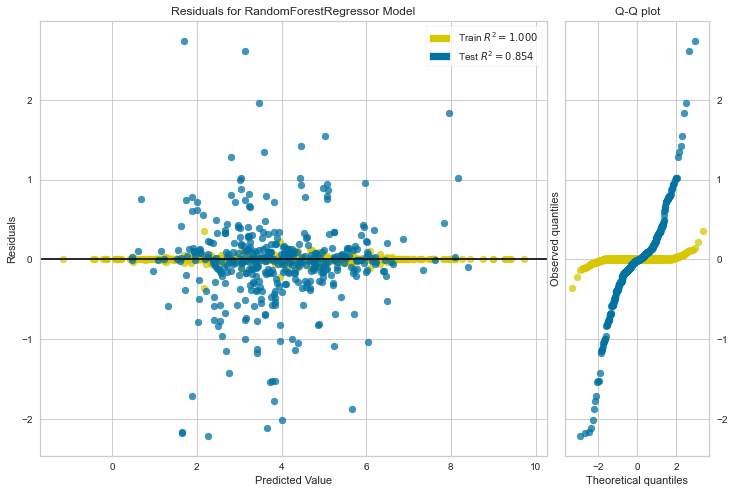

In [46]:
plot_resid(rfc_star, False, True, X_train_star, y_train_star, X_test_star, y_test_star)


## XG Boost: CO2 Emissions

In [47]:
import xgboost as xgb

start_time = timeit.default_timer()

regressor = xgb.XGBRegressor(
    n_estimators = 1000,
    reg_lambda=1,
    gamma=0,
    max_depth = 6
)

regressor.fit(X_train_coem, y_train_coem)

y_pred_coemission5 = regressor.predict(X_test_coem)

elapsed = timeit.default_timer() - start_time
executionTimeMin = elapsed / 60

coemission_results = compare_models_df(coemission_results.copy(), 
                                        "XGBoost", 
                                        y_test_coem, y_pred_coemission5,
                                        elapsed, executionTimeMin)
coemission_results

,R-squared,MAE (version log),RMSLE (Root Mean Squared Log Error),Execution time in seconds
Dummy Regressor (strategy = 'mean'),-0.002,1.242,1.49,0.000627
Linear Regression,-0.752,1.022,2.036,0.005346
Random Forest,0.766,0.493,0.682,3.116027
Random Forest (Feature Selection),0.766,0.497,0.683,3.191708
Random Forest Best Model from Grid Search,0.778,0.391,0.665,3.838103
Random Forest with EnergyStar,0.823,0.412,0.566,2.672823
Random Forest (Feature Selection) with EnergyStar,0.824,0.414,0.565,2.726773
Random Forest Best Model from Grid Search with EnergyStar,0.854,0.329,0.515,1.911224
XGBoost,0.783,0.384,0.658,2.662412
XGBoost Best Model from Grid Search,NaN,NaN,NaN,NaN


In [ ]:
plot_resid(regressor, False, True, X_train_coem, y_train_coem, X_test_coem, y_test_coem)


In [ ]:
xgb_model =  xgb.XGBRegressor()

parameters = {'gamma': [0, 1],
              'reg_lambda': [1, 4],
              'learning_rate': [0.03, , 0.06, 0.1, 0.14, 0.17], #so called `eta` value
              'max_depth': range (2, 7, 1),
              'min_child_weight': [0.5, 1, 2, 4],
              'subsample': [0.8, 0.9, 0.95, 0.97, 1],
              'n_estimators': [200, 300, 500, 600, 900, 1000]
             }

XGBgs = GridSearchCV(xgb_model, parameters, n_jobs= -1, 
                     cv = 5, 
                     verbose = 4, refit=True, scoring = 'neg_root_mean_squared_error')

XGBgs.fit(X_train_coem, y_train_coem)

print(XGBgs.best_score_)
# Print les paramètres du meilleur modèle
print(XGBgs.best_params_)
clfXGB = XGBgs.best_estimator_
print('Test accuracy: %.3f' % clfXGB.score(X_test_coem, y_test_coem))


In [48]:
start_time = timeit.default_timer()

regressor = xgb.XGBRegressor(
    n_estimators = 900,
    reg_lambda = 1,
    gamma = 0,
    max_depth = 6,
    learning_rate = 0.1,
    min_child_weight = 1, 
    subsample = 0.8)

clfXGB = regressor.fit(X_train_coem, y_train_coem)

y_pred_coemission_xggs = clfXGB.predict(X_test_coem)

elapsed = timeit.default_timer() - start_time
executionTimeMin = elapsed / 60

coemission_results = compare_models_df(coemission_results.copy(), 
                                       "XGBoost Best Model from Grid Search", 
                                       y_test_coem, y_pred_coemission_xggs,
                                        elapsed, executionTimeMin)
coemission_results

,R-squared,MAE (version log),RMSLE (Root Mean Squared Log Error),Execution time in seconds
Dummy Regressor (strategy = 'mean'),-0.002,1.242,1.49,0.000627
Linear Regression,-0.752,1.022,2.036,0.005346
Random Forest,0.766,0.493,0.682,3.116027
Random Forest (Feature Selection),0.766,0.497,0.683,3.191708
Random Forest Best Model from Grid Search,0.778,0.391,0.665,3.838103
Random Forest with EnergyStar,0.823,0.412,0.566,2.672823
Random Forest (Feature Selection) with EnergyStar,0.824,0.414,0.565,2.726773
Random Forest Best Model from Grid Search with EnergyStar,0.854,0.329,0.515,1.911224
XGBoost,0.783,0.384,0.658,2.662412
XGBoost Best Model from Grid Search,0.799,0.393,0.632,2.313157


In [ ]:
plot_resid(regressor, False, True, X_train_coem, y_train_coem, X_test_coem, y_test_coem)


## XGBoost avec EnergyStar: CO2 Emissions

In [49]:
start_time = timeit.default_timer()

regressor = xgb.XGBRegressor(
    n_estimators= 1000,
    reg_lambda=1,
    gamma=0,
    max_depth= 6
)

regressor.fit(X_train_star, y_train_star)

y_pred_coemission_xgstar = regressor.predict(X_test_star)


elapsed = timeit.default_timer() - start_time
executionTimeMin = elapsed / 60

coemission_results = compare_models_df(coemission_results.copy(), 
                                       "XGBoost with EnergyStar", 
                                       y_test_star, y_pred_coemission_xgstar,
                                       elapsed, executionTimeMin)                                 

In [ ]:
# residual plot du modèle xg boost avec energystar pour la variable dépendente CO2 Emissions
plot_resid(regressor, False, True, X_train_star, y_train_star, X_test_star, y_test_star)


In [ ]:
xgb_model =  xgb.XGBRegressor()

# paramètres à tester avec le grid search
parameters = {'gamma': [0, 1],
              'reg_lambda': [1, 2],
              'learning_rate': [0.03, 0.06, 0.1, 0.15, 0.2], #so called `eta` value
              'max_depth': range (2, 7, 1),
              'min_child_weight': [0.2, 0.5, 1, 2],
              'subsample': [0.7, 0.8, 0.9, 0.95],
              'n_estimators': [200, 300, 400, 600, 1000], #number of trees, change it to 1000 for better results
             }

XGBgs = GridSearchCV(xgb_model, parameters, n_jobs= -1, 
                     cv = 5, 
                     verbose = 4, refit=True, scoring = 'neg_root_mean_squared_error')

XGBgs.fit(X_train_star, y_train_star)

# training score du meilleur modèle
print(XGBgs.best_score_)
# print les paramètres du meilleur modèle
print(XGBgs.best_params_)
# test score du meilleur modèle
clfXGB = XGBgs.best_estimator_
print('Test accuracy: %.3f' % clfXGB.score(X_test_star, y_test_star))

Le modèle ci-dessous, 'XG Boost Best Model from Grid Search with EnergyStar', est le meilleur modèle de prédiction pour la target "GHG Emissions"

In [50]:
# Ce modèle est le meilleur modèle de prédiction pour la target "GHG Emissions"

start_time = timeit.default_timer()

# meilleur modèle du grid search
regressor = xgb.XGBRegressor(
    n_estimators = 1000,
    reg_lambda = 1,
    gamma = 0,
    max_depth = 6,
    learning_rate = 0.1,
    min_child_weight = 0.2, 
    subsample = 0.8)

clfXGB = regressor.fit(X_train_star, y_train_star)

y_pred_coemission_xggs = clfXGB.predict(X_test_star)

elapsed = timeit.default_timer() - start_time
executionTimeMin = elapsed / 60

# on ajoute les résultats du meilleur modèle du grid search au dataframe de comparaison
coemission_results = compare_models_df(coemission_results.copy(), 
                                        "XGBoost Best Model from Grid Search with EnergyStar", 
                                       y_test_star, y_pred_coemission_xggs,
                                       elapsed, executionTimeMin)
                                                           
coemission_results

,R-squared,MAE (version log),RMSLE (Root Mean Squared Log Error),Execution time in seconds
Dummy Regressor (strategy = 'mean'),-0.002,1.242,1.49,0.000627
Linear Regression,-0.752,1.022,2.036,0.005346
Random Forest,0.766,0.493,0.682,3.116027
Random Forest (Feature Selection),0.766,0.497,0.683,3.191708
Random Forest Best Model from Grid Search,0.778,0.391,0.665,3.838103
Random Forest with EnergyStar,0.823,0.412,0.566,2.672823
Random Forest (Feature Selection) with EnergyStar,0.824,0.414,0.565,2.726773
Random Forest Best Model from Grid Search with EnergyStar,0.854,0.329,0.515,1.911224
XGBoost,0.783,0.384,0.658,2.662412
XGBoost Best Model from Grid Search,0.799,0.393,0.632,2.313157


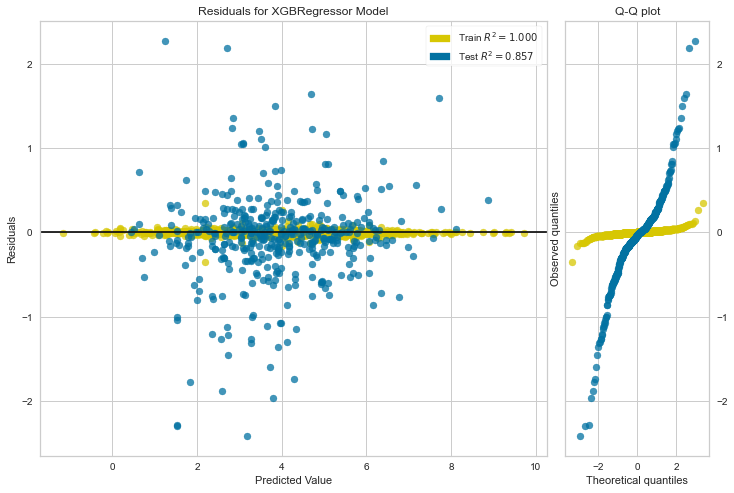

In [51]:
plot_resid(regressor, False, True, X_train_star, y_train_star, X_test_star, y_test_star)
